# Graph to visualize Twitter performance on LDA.

This notebook is used for subsection 1. What is the optimal number of topics that can be generatedon a set of Twitter messages using a topic model?

In [1]:
#basic python methods
import pandas as pd 
import re
import numpy as np
import umap

#gensim models for topic modeling
import gensim
import gensim.models.ldamodel
from gensim.test.utils import common_dictionary, common_corpus

#visualizations tools
import matplotlib.pyplot as plt
from matplotlib import pyplot

#nlp tools
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Import dataset

In [3]:
df = pd.read_csv(r"C:\Users\User\Documents\Thesis\data\twitter_dataset.csv", delimiter = ';')
df = df[0:20000]
df.dropna()

,message,event.cemistry.hashtags
0,#NYC #BROOKLYN please keep your eyes out!!! Pl...,"[ NYC, BROOKLYN, BOOST, QUEER ]"
1,"NEW YORK, Kayla has been missing for almost 48...","[ BOOST, NEWYORK ]"
2,"NEW YORK, Kayla has been missing for almost 48...","[ BOOST, NEWYORK ]"
3,@rohan_connolly #silentmajority #hush,"[ silentmajority, hush ]"
4,Ces travaux d'intérêt général auront lieu le 1...,"[ Burundi, YagaNawe ]"
...,...,...
19995,Need more reasons to attend the 2019 #ChemShow...,"[ ChemShow, CPI ]"
19996,#Burundi — This man is from Kayogoro/Makamba p...,[ Burundi ]
19997,Shots from Sydney Dragway.⁣\n.⁣\n© MPN Digital...,"[ nofilter, DragRacing, hitithard, neverlift, ..."
19998,#Burundi \n#BurundiCrisis,"[ Burundi, BurundiCrisis ]"


Nltk has libaries for common English, French and Spanish words. For other stopwords this set is created.

In [4]:
stopwords_mix = {'oya','ego','canke','amp','&amp','&amp', 'http', 'https', 'plus', 'contre', 'nest', 'cest' ,'après', 'cette', 'burundi', 'comme', 'burundais', 'ong','tout', 'sans',
                     'depuis', 'ils', 'si', 'tous','leurs', 'parti', 'ans', 'selon', 'info','faire',
                     'deux','fait','pace', 'period.','exceeding', 'year-earlier','soaring.'
                    , 'new', 'avoir','très','non','vient','où','quil','jour','encore','get','one', 
                     'like', 'need', 'since','time','last','got','know','well','real','via',"del","por","el","los",
                    "para","di","una","al","https","nhttps",'amp','&amp;','&','!','?',':','-',"alors","au","aucuns","aussi","autre","avant","avec","avoir", "aux","bon","car","ce","cela","ces","ceux","chaque","ci","comme","comment","dans","des",
                    "du","dedans","dehors","depuis","devrait","doit","donc","dos","début","elle","elles","en","encore","essai","est","et","eu","fait","faites","fois",
                    "font","hors","ici","il","ils","je","juste","la","le","les","leur","là","ma","maintenant","mais","mes","mine","moins","mon","mot","même","ni","nommés","notre","nous",
                    "ou","où","par","parce","pas","peut","peu","plupart","pour","pourquoi","quand","que","quel","quelle","quelles","quels","qui","sa","sans","ses",
                    "seulement","si","sien","son","sont","sous","soyes","sujet","sur","ta","tandis","tellement","tels","tes","ton","tous","tout","trop","très","tu","voient",
                    "un","une","vont","votre","vous","vu","ça","étaient","état","étions","été","être","ne","se","y","ont","nos","dit","dire",
                   "c","d","lui","l","moi","va","n","na","rien","autres","bien","sera","suis","vie","soit","quon",
                   "bonne","quils","jamais","entre","k","te","ourselves", "hers", "between", "yourself", "but", "again", "there", "about", "once", 
                     "during", "out", "very", "having", "with", "they", "own", "an", "be", "some", "for", 
                     "do", "de", "its", "yours", "such", "into", "of", "most", "itself", "other", "off", "is", "s", 
                     "am", "or", "who", "as", "from", "him", "each", "the", "themselves", "until", "below", "are", 
                     "we", "these", "your", "his", "through", "don", "nor", "me", "were", "her", "more", "himself", 
                     "this", "down", "should", "our", "their", "while", "above", "both", "up", "to", "ours", "had", 
                     "she", "all", "no", "when", "at", "any", "before", "them", "same", "and", "been", "have", "in", 
                     "will", "on", "does", "yourselves", "then", "that", "because", "what", "over", "why", "so", "can",
                     "did", "not", "now", "under", "he", "you", "herself", "has", "just", "where", "too", "only", "myself",
                     "which", "those", "i", "after", "few", "whom", "t", "being", "if", "theirs", "my", "against", "a", "by",
                     "doing", "it", "how", "further", "was", "here", "than", "https","nhttps",'amp','&amp;','&','!','?',':','-'}

Non-informative words are removed from the Twitter messages.

In [10]:
def clean_message(current_message):
    new_string = ""
    p = re.compile('@[a-zA-Z]+')
    findall = p.findall(str(current_message))
    current_message = re.sub(r'@[a-zA-Z]+', '', str(current_message))
    current_message = re.sub(r'[^a-zA-Z ]', '', str(current_message))
    for word in current_message.lower().split(" "):
   
        if not word.startswith("@" or "#" or "http"):
            if not word in set(stopwords.words("english")):
                if not word in set(stopwords.words("french")):
                    if not word in set(stopwords.words("spanish")):
                        if len(word) > 1:
                            if not word in stopwords_mix:
                     
                                new_string += (str(word) + " ")
    return(new_string)

    

In [6]:
def tokenize_message(current_message):
    new_list = []
    p = re.compile('@[a-zA-Z]+')
    findall = p.findall(str(current_message))
    current_message = re.sub(r'@[a-zA-Z]+', '', str(current_message))
    current_message = re.sub(r'[^a-zA-Z ]', '', str(current_message))
    for word in current_message.lower().split(" "):
   
        if not word.startswith("@" or "#" or "http"):
            if not word in set(stopwords.words("english")):
                if not word in set(stopwords.words("french")):
                    if not word in set(stopwords.words("spanish")):
                        if len(word) > 1:
                            if not word in stopwords_mix:
                     
                                new_list.append(str(word))
    return(new_list)

Tokenized messages are used as input to train a dictionary. 1000 most common words are kept. A word corpus is created form the dictionary.

In [7]:
df.dropna()

df['clean_message'] = df['message'].apply(clean_message)

df['tokenize_message'] = df['message'].apply(tokenize_message)

dictionary = gensim.corpora.Dictionary(df['tokenize_message'])

dictionary.filter_extremes(no_below=1, no_above=0.5, keep_n=1000)

bow_corpus = [dictionary.doc2bow(doc) for doc in df['tokenize_message']]

# Calculate perplexity




$$perplexity(D{_{test}}) = exp(\frac{\Sigma^{M}_{d=1}log\quad  p(W{_d})}  {\Sigma^{M}_{d=1}N_{d}})$$

In [8]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LsiModel(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=2, workers=2)
        Perplexity = lda_model.log_perplexity(corpus)
        c_v.append(Perplexity)
        
    # Show graph
    x = range(1, limit)
    print(c_v)
    plt.plot(x, c_v)
    plt.xlabel("num topics")
    plt.ylabel("Perplexity score")
    plt.show()
    

For each subset the perplexity is calculated for a number of topic (num topics) between 1 and 30

[-6.332279635288144, -6.076768678124216, -5.898261649538463, -5.7618527600477, -5.704346389702396, -5.595459811768565, -5.531842964122197, -5.4630874918259815, -5.404892748449196, -5.422883099834898, -5.348187256402203, -5.363151112768738, -5.286252293020941, -5.631206440757543, -5.801540583439304, -6.0853687240746455, -6.219740361080028, -6.308492288498849, -6.34948670457368, -6.485065429370574, -6.459610826330916, -6.474571268100043, -6.504069054536582, -6.589918823389807, -6.637220391832856, -6.686838090473453, -6.687291548647586, -6.780134878018838, -6.810853424935464]


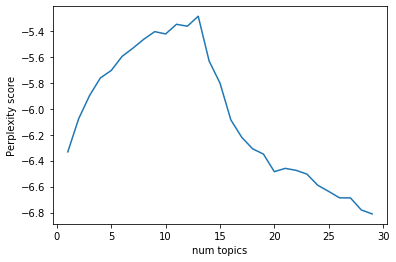

In [9]:
evaluate_graph(dictionary, bow_corpus, df['tokenize_message'], 30)

Output values per subset

In [3]:
x = range(1,30)
c_v_1 = [-6.260151064871227, -6.070954253648308, -5.959431363173436, -5.820987060234869, -5.664705467632515, -5.624578716211058, -5.580053959606182, -5.489310855620417, -5.4022948948108445, -5.4522308626722475, -5.337423094253439, -5.383467840919777, -5.397939148180106, -5.630666804104109, -5.861034811335414, -6.085066885538442, -6.214828741888701, -6.303201046608537, -6.41421197256781, -6.405777897248268, -6.436897210127642, -6.499731686068949, -6.563026006827553, -6.532557897078883, -6.575300356853622, -6.639383473644698, -6.738918946787044, -6.757775739852644, -6.823172229361924]
c_v_2 = [-6.478027175239665, -6.265920497963924, -6.14681076993804, -6.093722871393926, -6.056795661220847, -5.997573514606842, -5.937785136175312, -5.934604069939092, -5.830364515464048, -5.848562647978923, -5.8194097219228444, -5.792412056409235, -5.797485013593312, -5.8593316758841745, -5.864892553188192, -5.897380857907413, -5.812266551317347, -5.865117217110371, -5.914530272332627, -5.892763968987582, -5.818169536554785, -5.829592799549786, -5.8455658944692654, -5.894891670047674, -5.872267052522162, -5.865324177078799, -5.9695204921554055, -5.882230979774075, -5.90388117024659]
c_v_3 = [-6.451051004549226, -6.259738811822435, -6.155914492169648, -5.968790205579876, -5.9508002653910905, -5.811024163945181, -5.789454131847168, -5.681525760713365, -5.646049466022005, -5.598251319352978, -5.582775977372035, -5.540563833192596, -5.635909690504928, -5.60623786252898, -5.79091022888713, -5.932299239807484, -6.066914350090705, -6.064944632664488, -6.115796662855237, -6.147491359424617, -6.120165482572288, -6.077045521465957, -6.187253257194053, -6.196416691543667, -6.245536092497746, -6.280014623022965, -6.334479442508308, -6.336916368897657, -6.353706080567861]
c_v_4 = [-6.508347252221641, -6.372320428845667, -6.18809338522716, -6.152876463521209, -6.189086017766435, -6.055398186718619, -6.0128388114141815, -5.911157463769776, -5.963803583653066, -5.879303311911867, -5.882001728026227, -5.970319410694268, -5.939811772127745, -6.095017295643455, -6.217373905405645, -6.368579288286893, -6.4527950513761185, -6.424816250295514, -6.512615949649359, -6.526342246343651, -6.541283986090482, -6.532780520685324, -6.572239208358363, -6.597314808675833, -6.6072309089413475, -6.665281047895302, -6.707836664650774, -6.7057039559300495, -6.736238033670805]
c_v_5 = [-5.6533877665368815, -5.29199901595603, -5.095827283266201, -5.024070163006704, -4.879346551053596, -4.84734307299104, -4.798887411642895, -4.755618397546587, -4.7427498401704895, -4.740040835590963, -4.637004874318166, -4.569380827169158, -4.594905072827282, -4.600457033055668, -4.564621761412745, -4.711147722877002, -4.639191485847082, -4.500822252446969, -4.512979995607599, -4.518464763721323, -4.512196421759631, -4.541851432015813, -4.48716311876491, -4.562960051501248, -4.548755711435468, -4.488671792094143, -4.517737271703858, -4.511434211465276, -4.4922187115458]

Plot to show the performance of five subsets using LDA algoritm.

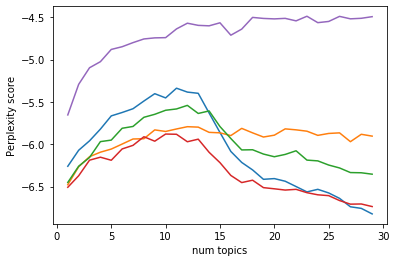

In [4]:
plt.plot(x, c_v_1)
plt.plot(x, c_v_2)
plt.plot(x, c_v_3)
plt.plot(x, c_v_4)
plt.plot(x, c_v_5)
plt.xlabel("num topics")
plt.ylabel("Perplexity score")
plt.show()